In [2]:
!pip install nb-black


[notice] A new release of pip is available: 23.0 -> 23.0.1
[notice] To update, run: python -m pip install --upgrade pip


In [3]:
!pip install "ray[tune]" "ray[default]"

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.0/3.0 MB 38.5 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 201.4/201.4 kB 34.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.8/56.8 kB 11.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.2/3.2 MB 87.3 MB/s eta 0:00:00:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 128.2/128.2 kB 26.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 90.5/90.5 kB 19.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.4/58.4 kB 12.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 120.3/120.3 kB 22.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 223.6/223.6 kB 36.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 73.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 178.1/178.1 kB 31.0 MB/s eta 0:00:00
  Created wheel for gpustat: filename=gpustat-1.0.0-py3-no

In [4]:
%config Completer.use_jedi = False
%load_ext autoreload
# %reload_ext autoreload
%autoreload 2
%load_ext lab_black

In [5]:
import sys

sys.path.insert(0, "../")

## Dataset

In [6]:
import os
from typing import Dict, List, Tuple, Any, Union, Callable
from torch import Tensor
import torch
import numpy as np
import scipy
from torch.utils.data import DataLoader
from pytorch_lightning.utilities.apply_func import apply_to_collection
from cspnn.data.bci.bci_dataset import BCI2aDataset
from cspnn.data.utils import eeg_electrode_configs

In [7]:
class ToTensor:
    def __init__(self, device):
        if isinstance(device, str):
            device = torch.device(device)
        self.device = device

    def __call__(self, data, label):
        data = apply_to_collection(
            data,
            dtype=(np.ndarray, int, float, np.int64),
            function=lambda a: torch.from_numpy(a),
        )
        label = apply_to_collection(
            label,
            dtype=(np.ndarray, int, float, np.int64),
            function=lambda a: torch.tensor(a, dtype=torch.float64),
        )

        return data, label


class ToNumpy:
    def __call__(self, data, label):
        data = apply_to_collection(
            data,
            dtype=(np.ndarray, int, float, np.int64),
            function=lambda a: a.cpu().detach().numpy(),
        )
        label = apply_to_collection(
            label,
            dtype=(np.ndarray, int, float, np.int64),
            function=lambda a: a.cpu().detach().numpy(),
        )

        return data, label


class DictToTensor:
    def __call__(self, data: Dict[str, Tensor], label):
        # The output shape [batch, channel, signal]
        return (
            torch.permute(
                torch.vstack(list(map(lambda a: a.unsqueeze(0), data.values()))),
                (1, 0, 2),
            ),
            label,
        )


class DictToArray:
    def __call__(self, data, label):
        # The output shape [batch, channel, signal]
        return (
            np.transpose(
                np.vstack(
                    list(map(lambda a: np.expand_dims(a, axis=0), data.values()))
                ),
                (1, 0, 2),
            ),
            label,
        )


class Windowing:
    def __init__(self, n_segments: int = 5, sample_rate: float = 250.0):
        self.n_segments = n_segments
        self.sample_rate = sample_rate

    # The Output of the signal is [batch, channels, windowed, band_filtered, signal]
    def __call__(self, data: Tensor, label):
        """Takes as input a signal tensor of shape [batch, channels, band_filtered, signal]
        and outputs a signal tensor of shape [batch, channels, windowed, band_filtered, signal]
        """
        start, end = 0, data.size()[-1]
        step = int((end - start) / self.n_segments)
        windows = np.arange(start, end - step, step=step)

        if len(windows) == 0:
            data = data.unsqueeze(dim=2)
            return data, label

        windowed_data = torch.permute(
            torch.stack(
                [data[:, :, :, window : (window + step)] for window in windows], dim=0
            ),
            (1, 2, 0, 3, 4),
        )

        return windowed_data, label


class Filtering:
    def __init__(self, N: int, rs: float, Wns: List[float], bandwidth, fs: float):
        self.N = N
        self.rs = rs
        self.Wns = Wns / (fs / 2)  # Normalize the signals
        self.bandwidth = bandwidth / (fs / 2)  # Normalize the signals
        self.fs = fs

    # The Output of the signal is [batch, channels, band_filtered, signal]
    def __call__(self, data, label):
        filtered_data = []

        for wn in self.Wns:
            b, a = scipy.signal.cheby2(
                N=self.N,
                rs=self.rs,
                Wn=[wn, wn + self.bandwidth],
                btype="bandpass",
                fs=self.fs,
            )
            filtered_data.append(scipy.signal.filtfilt(b, a, data, axis=-1))

        filtered_data = torch.permute(torch.Tensor(filtered_data), (1, 2, 0, 3))

        return filtered_data, label


class ExpandDim(object):
    def __init__(self, dim):
        self.dim = dim

    def __call__(self, data, label):
        return data.unsqueeze_(self.dim), label


class LabelToDict:
    def __call__(self, data, label):
        return data, {"label": label}


class ToNumpy:
    def __call__(self, data, label):
        return data.cpu().detach().numpy(), label.cpu().detach().numpy()


class Compose:
    def __init__(self, transforms: List[Callable]) -> None:
        self.transforms = transforms

    def __call__(self, data: Any, target: Any):
        for t in self.transforms:
            data, target = t(data, target)
        return data, target

    def __repr__(self):
        return "\n".join([c.__class__.__name__ for c in self.transforms])


# TODO: complete this part
from scipy.signal import cheby2, filtfilt


def cheby_bandpass_filter(signal, attenuation, lowcut, highcut, fs, order=5):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = cheby2(order, rs=attenuation, Wn=[low, high], btype="band")
    y = filtfilt(b, a, signal, axis=-1)
    # print("filtered shape ", y.shape)
    return y


def cheby_bandpass_one_subject(
    X, attenuation, lowcut, highcut, fs, interval=None, verbose=True
):
    temp_epoch_EEG = X.copy()
    # print(f"data shape : {temp_epoch_EEG.shape}")

    if interval is not None:
        startband = np.arange(lowcut, highcut, step=interval)

        bands = []
        for start in startband:
            # This will be new key inside the EEG_filtered
            band = "{:02d}_{:02d}".format(start, start + interval)

            if verbose:
                print("Filtering through {} Hz band".format(band))
            # Bandpass filtering
            bands.append(
                cheby_bandpass_filter(
                    temp_epoch_EEG, attenuation, start, start + interval, fs
                )
            )

        return np.vstack(bands)

    else:
        # This will be new key inside the EEG_filtered
        band = "{:02d}_{:02d}".format(lowcut, highcut)

        return cheby_bandpass_filter(temp_epoch_EEG, attenuation, lowcut, highcut, fs)


from functools import partial


class BandPass:
    def __init__(self, attenuation, lowcut, highcut, fs, interval=None):
        self.attenuation = attenuation
        self.lowcut = lowcut
        self.highcut = highcut
        self.fs = fs
        self.interval = interval

        self.bandpass_func = partial(
            cheby_bandpass_one_subject,
            attenuation=self.attenuation,
            lowcut=self.lowcut,
            highcut=self.highcut,
            fs=self.fs,
            interval=self.interval,
            verbose=False,
        )

    # The Output of the signal is [batch, channels, band_filtered, signal]
    def __call__(self, data, label):
        filtered_data = data = apply_to_collection(
            data,
            dtype=(np.ndarray, int, float, np.int64, Tensor),
            function=self.bandpass_func,
        )

        filtered_data = np.expand_dims(filtered_data.transpose(1, 0, 2), axis=0)

        return filtered_data, label


class Whitening:
    def __init__(self, data_loader, whitening_method="PCA"):
        self.ds = data_loader
        self.method = whitening_method

        self.W = self._generate_whitening_transformation(self.ds, self.method)

    def _generate_whitening_transformation(self, data_loader, whitening_method="PCA"):
        """extract whitening transformation from data

        Parameters
        ----------
        data_loader : torch.dataloader
            pytorch data loader
        whitening_method : str
            one of following values
            "PCA" for PCA whitening
            "ZCA for ZCA whitening

        Returns
        -------
        torch.Tensor
            whitening transformation matrix
        """
        # get data
        signal = []
        for sig, lbl in data_loader:
            signal.append(sig)
        signal = torch.vstack(signal)

        # zero center
        x = signal.squeeze()
        sig = x.permute(0, 2, 1)
        x = torch.mean(sig, axis=1)
        x_mean = torch.mean(x, axis=0)

        x = sig - x_mean
        x_zero_centered = x.permute(0, 2, 1)

        # Calculate whitening matrix
        x_cov = self._calc_cov(x_zero_centered)

        lda, V = torch.linalg.eig(x_cov)
        lda, V = lda.real, V.real
        if "PCA":
            whitening_mat = torch.sqrt(torch.inverse(torch.diag(lda))) @ V.T
        elif "ZCA":
            whitening_mat = V @ torch.sqrt(torch.inverse(torch.diag(lda))) @ V.T

        return whitening_mat

    def _calc_cov(self, EEG_data):
        cov = []
        for i in range(EEG_data.size()[0]):
            cov.append(
                EEG_data[i] @ EEG_data[i].T / torch.trace(EEG_data[i] @ EEG_data[i].T)
            )

        cov = torch.mean(torch.stack(cov), 0)

        return cov

    def __call__(self, data: Tensor, label):
        whitened_data = self.W @ data
        return whitened_data, label

In [8]:
def collate_fn(batch):
    imgs = torch.vstack([item[0] for item in batch])

    trgts = {}
    sample_item_label = batch[0][1]
    for label_key in sample_item_label.keys():
        if isinstance(sample_item_label[label_key], dict):
            trgts[label_key] = {
                key: torch.vstack([item[1][label_key][key].squeeze() for item in batch])
                for key in sample_item_label[label_key].keys()
            }
        else:
            trgts[label_key] = torch.vstack(
                [item[1][label_key] for item in batch]
            ).squeeze()

    return [imgs, trgts]

In [9]:
directory = "../test_data"
electrod_positions, shape = eeg_electrode_configs(
    "../configs/eeg_recording_standard/international_10_20_22.py"
)
if not os.path.exists(directory):
    os.makedirs(directory)


def get_whitening_transform(
    directory, electrod_positions, collate_fn, whitening_method="ZCA"
):
    transforms = [
        ToTensor(device="cuda"),
        DictToTensor(),
        ExpandDim(dim=2),
        ExpandDim(dim=2),
        LabelToDict(),
    ]
    compose = Compose(transforms=transforms)

    ds = BCI2aDataset(
        eeg_electrode_positions=electrod_positions,
        data_path=directory,
        transforms=compose,
    )

    train_dataset, _ = ds.get_train_test_subsets()

    train_dataloader = DataLoader(
        train_dataset,
        batch_size=1,
        shuffle=False,
        collate_fn=collate_fn,
        num_workers=1,
    )

    return Whitening(train_dataloader, whitening_method=whitening_method)


########################################################################


def get_train_eval_dataloaders(
    directory, electrod_positions, collate_fn, batch_size=32, whitening_method="ZCA"
):
    if whitening_method:
        transforms = [
            ToTensor(device="cuda"),
            DictToTensor(),
            get_whitening_transform(
                directory,
                electrod_positions,
                collate_fn,
                whitening_method=whitening_method,
            ),
            ExpandDim(dim=2),
            ExpandDim(dim=2),
            LabelToDict(),
        ]
    else:
        transforms = [
            ToTensor(device="cuda"),
            DictToTensor(),
            ExpandDim(dim=2),
            ExpandDim(dim=2),
            LabelToDict(),
        ]
    compose = Compose(transforms=transforms)

    ds = BCI2aDataset(
        eeg_electrode_positions=electrod_positions,
        data_path=directory,
        transforms=compose,
        in_mem=True,
    )

    train_dataset, val_dataset = ds.get_train_test_subsets()

    train_dataloader = DataLoader(
        train_dataset,
        batch_size=batch_size,
        shuffle=True,
        collate_fn=collate_fn,
        num_workers=os.cpu_count(),
    )

    val_dataloader = DataLoader(
        val_dataset,
        batch_size=batch_size,
        collate_fn=collate_fn,
        num_workers=os.cpu_count(),
    )
    return train_dataloader, val_dataloader

## Model

In [10]:
import torch
import numpy as np
import torch.nn as nn
from cspnn.csp_nn import CSP, CSPNN

In [11]:
import torch.optim as optim

In [12]:
import numpy as np
from sklearn.metrics import (
    roc_auc_score,
    precision_score,
    recall_score,
    accuracy_score,
    cohen_kappa_score,
)
import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable
import torch.nn.functional as F
import torch.optim as optim

from tqdm import tqdm
import random

In [13]:
class SeparableConv2D(nn.Module):
    """https://github.com/seungjunlee96/Depthwise-Separable-Convolution_Pytorch/blob/master/DepthwiseSeparableConvolution/DepthwiseSeparableConvolution.py"""

    def __init__(
        self,
        in_channels,
        out_channels,
        depth_multiplier=1,
        kernel_size=3,
        padding="valid",
        bias=False,
    ):
        super(SeparableConv2D, self).__init__()
        self.depthwise = DepthwiseConv2d(
            in_channels, depth_multiplier, kernel_size, padding=padding, bias=bias
        )
        self.pointwise = nn.Conv2d(in_channels, out_channels, kernel_size=1, bias=bias)

    def forward(self, x):
        out = self.depthwise(x)
        out = self.pointwise(out)
        return out


class DepthwiseConv2d(nn.Conv2d):
    def __init__(
        self,
        in_channels,
        depth_multiplier=1,
        kernel_size=3,
        stride=1,
        padding=0,
        dilation=1,
        bias=True,
        padding_mode="zeros",
    ):
        out_channels = in_channels * depth_multiplier
        super().__init__(
            in_channels=in_channels,
            out_channels=out_channels,
            kernel_size=kernel_size,
            stride=stride,
            padding=padding,
            dilation=dilation,
            groups=in_channels,
            bias=bias,
            padding_mode=padding_mode,
        )


class EEGNetv2(nn.Module):
    """
    Note: Use this class carefully. It is specificaly adapted with BCI Comp. IV 2a
        (22 channels, sample rate of 250, 3 seconds). So it's not a general class.
        it is developed only for experiment purposes.
    Implemented based on keras/tensorflow implementation found here:
        https://github.com/vlawhern/arl-eegmodels
    Paper:
        https://iopscience.iop.org/article/10.1088/1741-2552/aace8c
    """

    def __init__(
        self,
        num_classes=4,
        channels=22,
        dropout_rate=0.5,
        kernel_length=64,
        F1=8,
        D=2,
        F2=16,
    ):
        super(EEGNetv2, self).__init__()
        self.dropout_rate = dropout_rate

        # Layer 1
        self.conv1 = nn.Conv2d(
            num_classes, F1, (1, kernel_length), padding="valid", bias=False
        )
        self.batchnorm1 = nn.BatchNorm2d(F1, False)
        self.dwconv2 = DepthwiseConv2d(
            in_channels=F1,
            depth_multiplier=D,
            kernel_size=(channels, 1),
            stride=1,
            padding="valid",
            bias=False,
        )

        self.batchnorm2 = nn.BatchNorm2d(2 * F1, False)
        # act elu
        self.pooling1 = nn.AvgPool2d((1, 4))
        # dropout

        # Layer 2
        self.sepconv2 = SeparableConv2D(2 * F1, F2, 1, (1, 16), padding="same")
        self.batchnorm3 = nn.BatchNorm2d(F2, False)
        # elu
        self.pooling2 = nn.AvgPool2d((1, 8))
        # dropout

        # FC Layer
        self.fc1 = nn.Linear(16 * 30, 4)

    def _forward_emb(self, x, device=None):
        # Layer 1
        # print(f"{x.size()}")
        x = self.conv1(x)
        # print(f"{x.size()}")
        x = self.batchnorm1(x)

        x = self.dwconv2(x)
        # print(f"{x.size()}")
        x = self.batchnorm2(x)
        x = F.elu(x)
        x = self.pooling1(x)
        if self.training:
            x = F.dropout(x, self.dropout_rate)

        x = self.sepconv2(x)
        # print(f"{x.size()}")
        x = self.batchnorm3(x)
        x = F.elu(x)
        x = x.squeeze()
        x = self.pooling2(x)
        # print(f"{x.size()}")
        if self.training:
            x = F.dropout(x, self.dropout_rate)

        # FC Layer
        x = x.reshape((-1, 16 * 30))
        return x

    def forward(self, x, device=None):
        x = self._forward_emb(x)
        x = F.softmax(self.fc1(x), dim=1)
        return x


class CSPNNCls(nn.Module):
    def __init__(
        self,
        num_channels: int,
        num_features: int = None,
        num_bands: int = None,
        num_windows: int = 1,
        num_labels: int = None,
        csp_pow: bool = True,
        signal_len: int = None,
        mode: str = "constant",
    ):
        super(CSPNNCls, self).__init__()
        self.num_channels = num_channels
        self.num_features = num_channels if num_features is None else num_features
        self.num_bands = num_bands
        self.num_windows = num_windows
        self.num_labels = num_labels
        self.csp_pow = csp_pow
        if not self.csp_pow:
            self.signal_len = signal_len
        self.mode = mode

        self.conv1 = CSPNN(
            num_channels=num_channels,
            num_features=num_features,
            num_bands=num_bands,
            num_windows=num_windows,
            num_labels=num_labels,
            csp_pow=csp_pow,
            mode=self.mode,
        )

        if self.csp_pow:
            csp_feature_size = (
                self.num_bands * self.num_windows * self.num_labels * self.num_features
            )
        else:
            csp_feature_size = (
                self.num_bands
                * self.num_windows
                * self.num_labels
                * self.num_features
                * 51
            )

        self.eegnet = EEGNetv2(
            num_classes=4,
            channels=22,
            dropout_rate=0.5,
            kernel_length=32,
            F1=8,
            D=2,
            F2=16,
        )

    def forward(self, x):
        csp = self.conv1(x)

        # features = csp.reshape(
        #     (csp.size()[0] * csp.size()[1], self.num_channels, -1)  # batch * labels
        # )

        features = csp.reshape(
            (csp.size()[0], self.num_channels, csp.size()[1], -1)  # batch * labels
        )
        features = features.permute(0, 2, 1, 3)

        x = self.eegnet(features)

        if self.training:
            return x, csp
        return x

## Train Loop

In [14]:
import ray
import ray.tune as tune
from ray import air

In [15]:
def evaluate(model, dl, cls_criterion, params=["acc"]):
    model.eval()
    results = []
    predicted = []
    Y = []

    for batch in dl:
        inputs, labels = batch
        # inputs = torch.permute(
        #     torch.vstack(list(map(lambda a: a.unsqueeze(0), inputs.values()))),
        #     (1, 2, 3, 0),
        # )
        # wrap them in Variable
        # inputs, labels = inputs.cuda(0), labels.type(torch.LongTensor).cuda(0)

        pred = model(inputs.float().cuda(0))

        predicted.append(pred.cpu().detach())
        Y.append(labels["label"].type(torch.LongTensor).cpu())

    predicted = torch.cat(predicted, 0)
    Y = torch.cat(Y, 0)

    loss = cls_criterion(predicted, Y)

    predicted = predicted.numpy()
    Y = Y.numpy()

    for param in params:
        if param == "acc":
            results.append(accuracy_score(Y, np.argmax(predicted, axis=1)))
        if param == "auc":
            results.append(roc_auc_score(Y, predicted, multi_class="ovr"))
        if param == "kappa":
            results.append(cohen_kappa_score(Y, np.argmax(predicted, axis=1)))
        if param == "recall":
            results.append(
                recall_score(Y, np.argmax(predicted, axis=1), average="micro")
            )
        if param == "precision":
            results.append(
                precision_score(Y, np.argmax(predicted, axis=1), average="micro")
            )
        if param == "fmeasure":
            precision = precision_score(
                Y, np.argmax(predicted, axis=1), average="micro"
            )
            recall = recall_score(Y, np.argmax(predicted, axis=1), average="micro")
            results.append(2 * precision * recall / (precision + recall))

    results.append(loss)
    return results

In [16]:
def train(config):
    directory = "/opt/ext/home/arman/csp-nn/test_data"
    batch_size = config["batchsize"]

    train_dataloader, val_dataloader = get_train_eval_dataloaders(
        directory,
        electrod_positions,
        collate_fn,
        batch_size=batch_size,
        whitening_method=config["whitening_method"],
    )
    net = CSPNNCls(
        num_channels=22,
        num_features=22,
        num_bands=1,
        num_windows=1,
        num_labels=4,
        csp_pow=False,
        signal_len=1001,
        mode="csp",
    )
    net = net.to("cuda")

    criterion = nn.CrossEntropyLoss()  # nn.BCELoss()

    if config["optim"] == "Adam":
        optimizer = optim.Adam(net.parameters(), lr=config["lr"], weight_decay=0.00)
    else:
        optimizer = optim.SGD(
            net.parameters(),
            lr=config["lr"],
            momentum=0.9,
            nesterov=True,
            weight_decay=0,
        )

    # optimizer = optim.SGD(
    #     [
    #         {"params": net.conv1.parameters()},
    #         {"params": net.fc2.parameters(), "weight_decay": 5e-3},
    #         # {"params": net.fc1.parameters(), "weight_decay": 5e-3},
    #         {"params": net.fc.parameters()},
    #     ],
    #     lr=0.001,
    #     momentum=0.9,
    #     nesterov=True,
    #     weight_decay=0,
    # )

    # lr_scheduler = torch.optim.lr_scheduler.OneCycleLR(
    #     optimizer, max_lr=0.1, steps_per_epoch=1, epochs=200
    # )
    lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=250, gamma=0.1)

    alpha = 0.5

    for epoch in range(1000):  # loop over the dataset multiple times
        net.train()
        running_loss = 0.0
        for i, batch in enumerate(train_dataloader):
            # print(i)
            inputs, labels = batch

            # wrap them in Variable
            inputs, labels = inputs.float().cuda(0), labels["label"].type(
                torch.LongTensor
            ).cuda(0)

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            outputs, csp_out = net(inputs)
            loss = criterion(outputs, labels)
            loss.backward()

            optimizer.step()

            running_loss += loss.item()

        # print(optimizer.param_groups[0]["lr"])
        lr_scheduler.step()

        # Validation accuracy
        # params = ["acc", "kappa", "auc", "fmeasure", "loss"]
        params = ["acc", "kappa", "fmeasure", "loss"]
        tr = evaluate(net, train_dataloader, criterion, params)
        ev = evaluate(net, val_dataloader, criterion, params)

        #         history["train_kappa"].append(tr[1])
        #         history["train_fmeasure"].append(tr[2])

        #         history["test_kappa"].append(ev[1])
        #         history["test_fmeasure"].append(ev[2])

        tune.report(
            epoch=epoch,
            lr=optimizer.param_groups[0]["lr"],
            train_loss=tr[-1],
            train_accuracy=tr[0],
            test_loss=ev[-1],
            test_accuracy=ev[0],
        )

search_space = {
    "lr": tune.choice([0.1, 0.01, 0.001, 0.0001]),
    "optim": tune.choice(["Adam", "SGD"]),
    "momentum": tune.sample_from(
        lambda spec: np.random.uniform(0.1, 0.9) if spec.config.optim == "SGD" else None
    ),
    "batchsize": tune.choice([16, 32, 64, 128]),
    "cwd": os.getcwd(),
}

In [17]:
# Total of 3×5×3+3×5×5×3 trials
search_space = {
    "lr": tune.grid_search([0.01, 0.001, 0.0001]),
    "optim": tune.grid_search(["Adam", "SGD"]),
    "momentum": tune.sample_from(
        lambda spec: [0.1, 0.3, 0.5, 0.7, 0.9] if spec.config.optim == "SGD" else None
    ),
    "batchsize": tune.grid_search([32, 64, 128, 256, 512]),
    "whitening_method": tune.grid_search(["ZCA", "PCA", None]),
}

In [18]:
!ls /root

ray_results


In [19]:
!rm -r /root/ray_results

In [ ]:
runtime_env = {"env_vars": {"PYTHONPATH": "/opt/ext/home/arman/csp-nn/"}}
ray.shutdown()
ray.init(runtime_env=runtime_env)

trainable_with_resources = tune.with_resources(train, {"gpu": 1 / 6, "cpu": 1})
tuner = tune.Tuner(
    trainable_with_resources,
    tune_config=tune.TuneConfig(num_samples=5),
    run_config=air.RunConfig(local_dir="./ray_results", name="test_experiment"),
    param_space=search_space,
)
results = tuner.fit()
ray.shutdown()

2023-04-02 19:32:53,184	INFO worker.py:1544 -- Started a local Ray instance. View the dashboard at http://127.0.0.1:8265 


(raylet) /usr/lib/python3/dist-packages/requests/__init__.py:89: RequestsDependencyWarning: urllib3 (1.26.12) or chardet (3.0.4) doesn't match a supported version!
(raylet)   warnings.warn("urllib3 ({}) or chardet ({}) doesn't match a supported "
(raylet) /usr/lib/python3/dist-packages/requests/__init__.py:89: RequestsDependencyWarning: urllib3 (1.26.12) or chardet (3.0.4) doesn't match a supported version!
(raylet)   warnings.warn("urllib3 ({}) or chardet ({}) doesn't match a supported "
(raylet) /usr/lib/python3/dist-packages/requests/__init__.py:89: RequestsDependencyWarning: urllib3 (1.26.12) or chardet (3.0.4) doesn't match a supported version!
(raylet)   warnings.warn("urllib3 ({}) or chardet ({}) doesn't match a supported "
(raylet) /usr/lib/python3/dist-packages/requests/__init__.py:89: RequestsDependencyWarning: urllib3 (1.26.12) or chardet (3.0.4) doesn't match a supported version!
(raylet)   warnings.warn("urllib3 ({}) or chardet ({}) doesn't match a supported "
(raylet) /us

Trial name,date,done,episodes_total,epoch,experiment_id,hostname,iterations_since_restore,lr,node_ip,pid,test_accuracy,test_loss,time_since_restore,time_this_iter_s,time_total_s,timestamp,timesteps_since_restore,timesteps_total,train_accuracy,train_loss,training_iteration,trial_id,warmup_time
train_29698_00000,2023-04-02_21-01-51,False,,347,3a0331fdc483462289850feb604775e4,46c388e6a26e,348,0.001,172.18.0.2,280233,0.5837191358024691,1.159252643585205,5331.255078315735,15.35149598121643,5331.255078315735,1680469311,0,,0.7002314814814815,1.0413007736206055,348,29698_00000,0.003715038299560547
train_29698_00001,2023-04-02_21-01-44,False,,428,a7293f2761e8408192c7077e76aa229c,46c388e6a26e,429,0.001,172.18.0.2,280300,0.5794753086419753,1.1599513292312622,5319.796944618225,12.095529317855835,5319.796944618225,1680469304,0,,0.7611882716049383,0.9798457622528076,429,29698_00001,0.0039479732513427734
train_29698_00002,2023-04-02_21-01-53,False,,523,9824c2e9b0c9429fa4d8302d4975d00e,46c388e6a26e,524,0.0001,172.18.0.2,280317,0.6122685185185185,1.127402901649475,5328.337345838547,10.248092651367188,5328.337345838547,1680469313,0,,0.8009259259259259,0.9420294165611267,524,29698_00002,0.004778623580932617
train_29698_00003,2023-04-02_21-01-51,False,,549,8d8d741124844265b7e97d8fb3f66924,46c388e6a26e,550,0.0001,172.18.0.2,280319,0.6138117283950617,1.1223101615905762,5326.948951482773,10.033137559890747,5326.948951482773,1680469311,0,,0.814429012345679,0.9265756607055664,550,29698_00003,0.004444122314453125
train_29698_00004,2023-04-02_19-33-05,,,,3d8b6f3847924f9694d61c34c927d06e,46c388e6a26e,,,172.18.0.2,280322,,,,,,1680463985,,,,,,29698_00004,
train_29698_00005,2023-04-02_19-33-04,,,,da47bc52201145c6ab3730f09e903ea6,46c388e6a26e,,,172.18.0.2,280324,,,,,,1680463984,,,,,,29698_00005,
train_29698_00006,2023-04-02_21-01-52,False,,407,65ef3c9d88dd401d98d09c8d6ce407ba,46c388e6a26e,408,0.0001,172.18.0.2,281972,0.6087962962962963,1.1175953149795532,5277.263729810715,13.253881216049194,5277.263729810715,1680469312,0,,0.8225308641975309,0.9289962649345398,408,29698_00006,0.0038788318634033203
train_29698_00007,2023-04-02_21-01-48,False,,493,4f740b4465864d489463e3271ee40373,46c388e6a26e,494,0.0001,172.18.0.2,282092,0.6157407407407407,1.1213953495025635,5273.129856348038,9.728715181350708,5273.129856348038,1680469308,0,,0.7885802469135802,0.9607061743736267,494,29698_00007,0.0038695335388183594


2023-04-02 19:33:38,004	ERROR ray_trial_executor.py:930 -- An exception occurred when trying to stop the Ray actor:Traceback (most recent call last):
  File "/usr/local/lib/python3.8/dist-packages/ray/tune/execution/ray_trial_executor.py", line 921, in _resolve_stop_event
    ray.get(future, timeout=timeout)
  File "/usr/local/lib/python3.8/dist-packages/ray/_private/client_mode_hook.py", line 105, in wrapper
    return func(*args, **kwargs)
  File "/usr/local/lib/python3.8/dist-packages/ray/_private/worker.py", line 2382, in get
    raise value
ray.exceptions.OutOfMemoryError: Task was killed due to the node running low on memory.
Memory on the node (IP: 172.18.0.2, ID: 60766f0c7207f1c544ac8ffb187459ddfa329030ea4e1cd302af16c2) where the task (actor ID: 3010dc2621b4078f326595d301000000, name=ImplicitFunc.__init__, pid=280322, memory used=0.02GB) was running was 58.33GB / 58.86GB (0.990882), which exceeds the memory usage threshold of 0.95. Ray killed this worker (ID: 126625c481fe85d902

In [ ]:
# Plot by epoch
ax = None  # This plots everything on the same plot
for d in dfs.values():
    ax = d.test_accuracy.plot(ax=ax, legend=False)

In [60]:
{k: history[k][-1] for k in history.keys()}

{'train_loss': tensor(1.0324),
 'test_loss': tensor(1.1398),
 'train_acc': 0.7114197530864198,
 'test_acc': 0.5891203703703703,
 'train_kappa': 0.6152263374485596,
 'test_kappa': 0.4521604938271605,
 'train_fmeasure': 0.7114197530864198,
 'test_fmeasure': 0.5891203703703703,
 'lr': 1.0000000000000006e-11}

In [61]:
idx = np.argmax(history["test_acc"])
{k: history[k][idx] for k in history.keys()}

{'train_loss': tensor(1.0269),
 'test_loss': tensor(1.1348),
 'train_acc': 0.7152777777777778,
 'test_acc': 0.597608024691358,
 'train_kappa': 0.6203703703703703,
 'test_kappa': 0.463477366255144,
 'train_fmeasure': 0.7152777777777778,
 'test_fmeasure': 0.597608024691358,
 'lr': 1.0000000000000004e-08}

In [50]:
import matplotlib.pyplot as plt

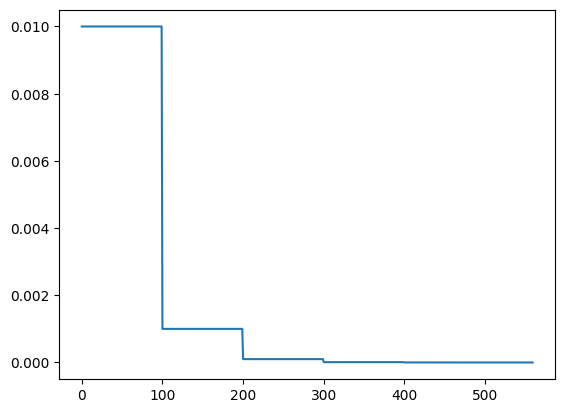

In [51]:
plt.plot([i for i in range(len(history["lr"]))], history["lr"])

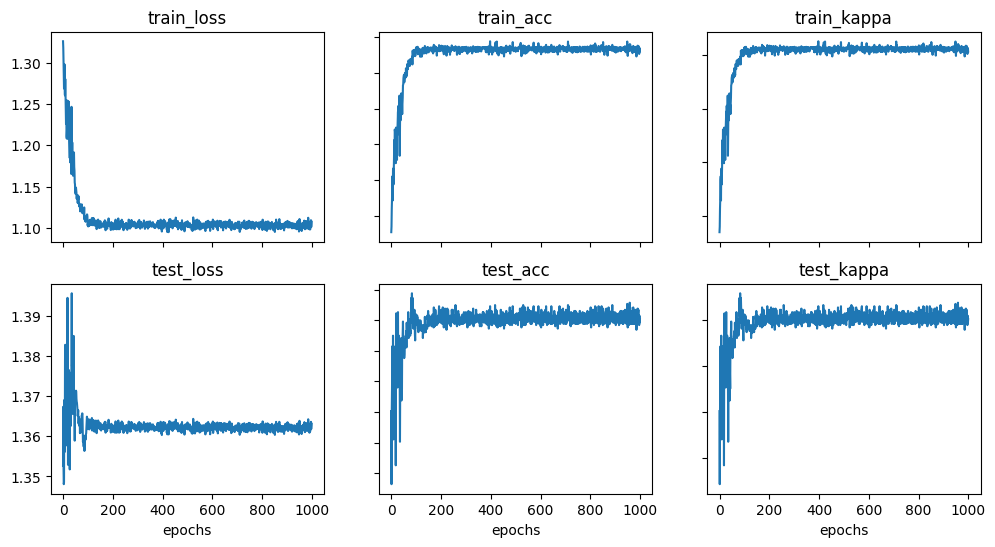

In [89]:
fig, axs = plt.subplots(2, 3, figsize=(12, 6))

for i, title in enumerate(
    [
        "train_loss",
        "train_acc",
        "train_kappa",
        "test_loss",
        "test_acc",
        "test_kappa",
    ]
):
    axs[i // 3, i % 3].plot([i for i in range(len(history[title]))], history[title])
    axs[i // 3, i % 3].set_title(title)

for ax in axs.flat:
    ax.set(xlabel="epochs", ylabel="")

# Hide x labels and tick labels for top plots and y ticks for right plots.
for ax in axs.flat:
    ax.label_outer()

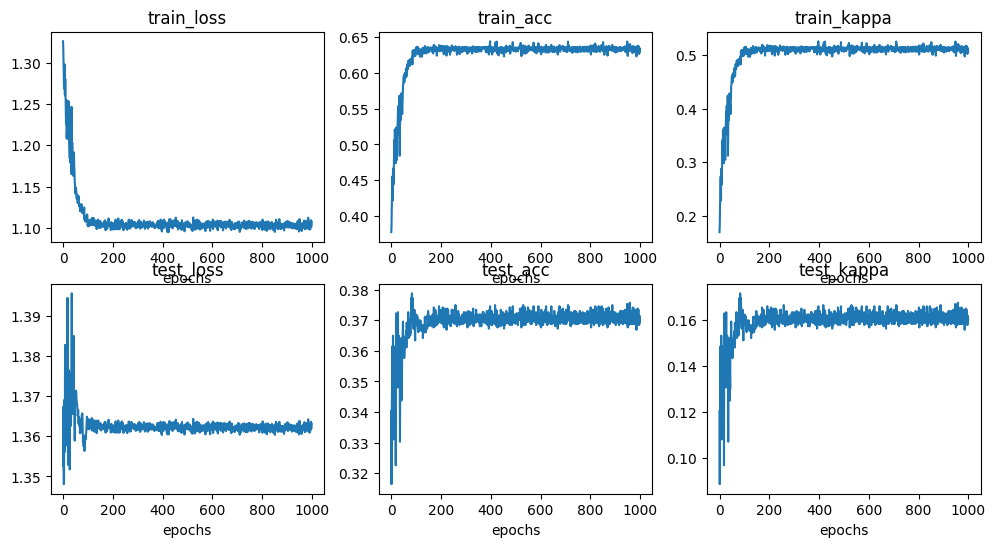

In [90]:
fig, axs = plt.subplots(2, 3, figsize=(12, 6))

for i, title in enumerate(
    [
        "train_loss",
        "train_acc",
        "train_kappa",
        "test_loss",
        "test_acc",
        "test_kappa",
    ]
):
    axs[i // 3, i % 3].plot([i for i in range(len(history[title]))], history[title])
    axs[i // 3, i % 3].set_title(title)

for ax in axs.flat:
    ax.set(xlabel="epochs", ylabel="")

# Hide x labels and tick labels for top plots and y ticks for right plots.
# for ax in axs.flat:
#     ax.label_outer()

In [36]:
a = 0.3549382716049383
print(f"{a:.2}")

0.35
